In [17]:
from pathlib import Path
from urllib.request import urlretrieve
import zipfile
from matplotlib.pyplot import imread
from scipy.ndimage.interpolation import zoom#
import numpy as np


def fetch_cropped_yaleb(data_folder, zooming=0.5, max_n_subjects=None):
    """Returns a dictionary of paths
    
    Parameters
    ----------
    data_folder: string
    zooming: float, optional, default is 0.5
        factor by which to resize the images
    max_n_subjects: {None, int}, optional, default is None
        if not None, only the first max_n_subjects are returned
    
    Returns
    -------
    dict: {
        subjects_1: {'images': [image_1, ... image_N],
               'ambient': image_ambient,
        }
    }
    
    images are stored as numpy arrays
    """
    url = 'http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip'
    yaleb_path = Path(data_folder).joinpath('cropped_yaleb')
    
    if not yaleb_path.joinpath('CroppedYale').exists():
        yaleb_path.mkdir(parents=True)
    
    # If not already unzip, do it
    if not list(yaleb_path.iterdir()):
        zip_path = yaleb_path.joinpath('yaleb.zip')
        
        # If zip not already downloaded, download it
        if not zip_path.exists():
            urlretrieve(url, zip_path.as_posix())
        
        zfile = zipfile.ZipFile(zip_path.as_posix())
        zfile.extractall(path=yaleb_path.as_posix())

    yaleb = {}
    for folder_path in yaleb_path.joinpath('CroppedYale').iterdir():
        if max_n_subjects is not None and len(yaleb) > max_n_subjects:
            return yaleb
        
        if not folder_path.is_dir():
            continue
            
        video_name = folder_path.name
        paths = sorted(list(folder_path.glob('*.pgm')))
        images = []
        for path in paths:
            if 'Ambient' in path.name:
                ambient = imread(path.as_posix())
            else:
                images.append(zoom(imread(path.as_posix()), zooming)[None, ...])
                
        data = {'images':np.concatenate(images),
        'ambient':ambient}
        yaleb[video_name] = data

    return yaleb

In [18]:
dataset_path = '/data/tensorly_data/'

data = fetch_cropped_yaleb(dataset_path, zooming=0.3, max_n_subjects=5)

In [19]:
data

{'yaleB01': {'images': array([[[ 80,  91,  95, ...,  77,  69,  71],
          [ 79,  90,  89, ...,  80,  68,  63],
          [ 79,  87,  96, ...,  78,  69,  56],
          ...,
          [ 20,  29,  32, ...,  42,  36,  34],
          [ 20,  20,  20, ...,  37,  23,  14],
          [ 12,  14,  18, ...,  24,  13,  11]],
  
         [[ 94, 105, 109, ...,  88,  80,  79],
          [ 87, 102, 105, ...,  91,  81,  70],
          [ 93,  96, 111, ...,  87,  79,  69],
          ...,
          [  8,  10,  17, ...,  23,  13,  14],
          [  7,  10,  11, ...,  14,  12,   8],
          [  4,  10,   8, ...,  14,   6,   8]],
  
         [[ 59,  89, 109, ...,  92,  73,  58],
          [ 75,  91, 110, ..., 100,  82,  88],
          [ 90,  99, 117, ...,  92,  78,  81],
          ...,
          [  4,   4,   5, ...,   8,   8,   7],
          [  4,   4,   3, ...,   8,   4,   6],
          [  3,   5,   4, ...,   7,   4,   7]],
  
         ...,
  
         [[  4,   4,   5, ..., 133, 141, 111],
          [ 

In [20]:
data.keys()

dict_keys(['yaleB01', 'yaleB02', 'yaleB03', 'yaleB04', 'yaleB05', 'yaleB06'])

In [21]:
data['yaleB01']['ambient'].shape

(192, 168)

In [22]:
data['yaleB01']['images'].shape

(64, 58, 50)

In [23]:
X = np.concatenate([data[key]['images'] for key in data], axis=0)

print(X.shape)

(384, 58, 50)


In [24]:
[(key, data[key]['images'][0,0,0]) for key in data] #play with list comprehension

[('yaleB01', 80),
 ('yaleB02', 86),
 ('yaleB03', 80),
 ('yaleB04', 64),
 ('yaleB05', 10),
 ('yaleB06', 57)]

In [25]:
def fetch_cropped_yaleb_testing(data_folder, zooming=0.5, max_n_subjects=None):
    
    yaleb_path = Path(data_folder).joinpath('cropped_yaleb')
  
    for folder_path in yaleb_path.joinpath('CroppedYale').iterdir():
         
        if not folder_path.is_dir():
            continue
            
        video_name = folder_path.name
        print(video_name)

    return 0

In [26]:
fetch_cropped_yaleb_testing(dataset_path, zooming=0.3, max_n_subjects=5)

yaleB01
yaleB02
yaleB03
yaleB04
yaleB05
yaleB06
yaleB07
yaleB08
yaleB09
yaleB10
yaleB11
yaleB12
yaleB13
yaleB15
yaleB16
yaleB17
yaleB18
yaleB19
yaleB20
yaleB21
yaleB22
yaleB23
yaleB24
yaleB25
yaleB26
yaleB27
yaleB28
yaleB29
yaleB30
yaleB31
yaleB32
yaleB33
yaleB34
yaleB35
yaleB36
yaleB37
yaleB38
yaleB39


0

In [27]:
X = X.astype(np.float64)
X -= X.mean()

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualise_images(X, n_images, n_columns, randomise=True):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_images]
    cmap = plt.cm.Greys_r
    n_rows = np.ceil(n_images / n_columns).astype(int)
    fig = plt.figure(figsize=(2*n_columns, 2*n_rows))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')

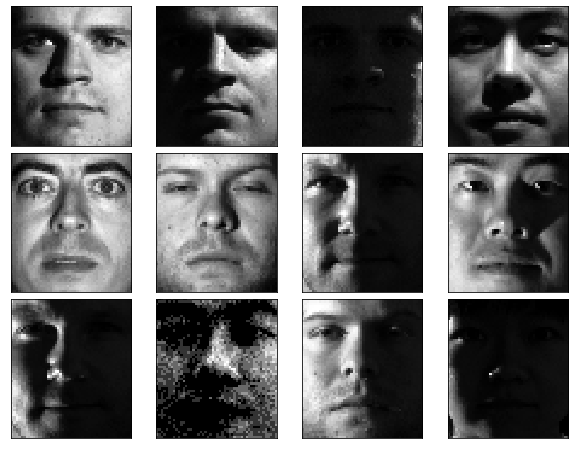

In [29]:
visualise_images(X, 12, 4)

In [30]:
import random
 
def add_noise(X, percent=0.15):
    num_images, row, col = X.shape
    
    n1 = int(row*col*percent)
    for i in range(num_images):
        
        fmin, fmax = np.min(X[i]), np.max(X[i])
        
        for j in range(n1):
    
            y_coord=random.randint(0, row - 1)
            x_coord=random.randint(0, col - 1)
            scale = random.randint(0, 100)/100 #random between 0 and 1
            val = fmin + scale*(fmax - fmin) #random betweeen fmin and fmax
            X[i,y_coord, x_coord]=val

In [31]:
add_noise(X)

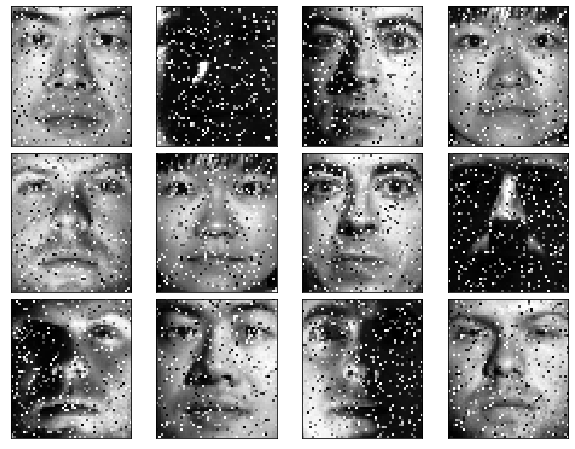

In [32]:
visualise_images(X, 12, 4)